In [13]:
file_path = '/Users/lfinkbeiner/Documents/GitHub/HERA/beam/'
beam_origin = 'HERA_4.9m_E-pattern_151MHz.txt'
beam_destination = 'ant1_s2'

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
from RIMEz import beam_models
import numpy as np
import healpy as hp
from spin1_beam_model import cst_processing, jones_matrix_field

In [15]:
processor = cst_processing.CSTDataProcessor(
    [file_path + beam_origin,
    file_path + beam_origin,
    file_path + beam_origin],
    np.array([150e6, 151e6, 152e6]),
    1, 1e-4
)

In [16]:
processor.compute_spin1_harmonics()
processor.write_model_data(file_path, beam_destination)
spline_beam_func = beam_models.model_data_to_spline_beam_func(file_path + beam_destination + '.h5', np.array([150e6, 151e6, 152e6]))

//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.pos1_Elm_samples = h5f["pos1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.neg1_Elm_samples = h5f["neg1_Elm"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:20: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.freq_nodes = h5f["frequencies"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.L_model = h5f["spatial_bandlimit"].value
//anaconda3/envs/hera/lib/python3.7/site-packages/spin1_beam_model/jones_matrix_field.py:22: H5pyDeprec

delta_nu_in is 1000000.0


In [17]:
import healpy as hp
#nside = 16, 32, 64, 128...
nside = 128

# healpix does the interpolation for you?
theta, phi = hp.pix2ang(nside,np.arange(12 * nside * nside))
az = phi
alt = np.pi / 2 - theta
J = spline_beam_func(150e6, alt, az)

In [18]:
# Current labels
# 0, 0 : xy
# 1, 0 : xx
# 0, 1 : yy
# 1, 1 : yx

J_abs = np.abs(J)
print(J_abs)
J_abs.shape

[[[0.00281558 0.99816552]
  [0.99816633 0.00251133]]

 [[0.00254597 0.99816624]
  [0.99816313 0.00285542]]

 [[0.00253712 0.99816399]
  [0.99816316 0.00284353]]

 ...

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]

 [[0.         0.        ]
  [0.         0.        ]]]


(196608, 2, 2)

In [19]:
test_index = hp.get_interp_val(np.abs(J[:, 0, 1]), -80, 60, False, True)

In [20]:
lat = np.linspace(-90, 90, 1000)
lon = np.linspace(-180, 180, 1000)

<IPython.core.display.Javascript object>


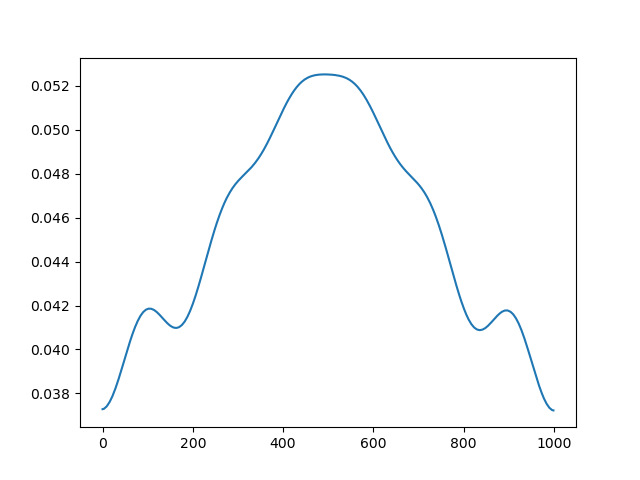

In [34]:
plt.plot(hp.get_interp_val(J_abs[:, 0, 1], lat, 60, False, True))

<IPython.core.display.Javascript object>


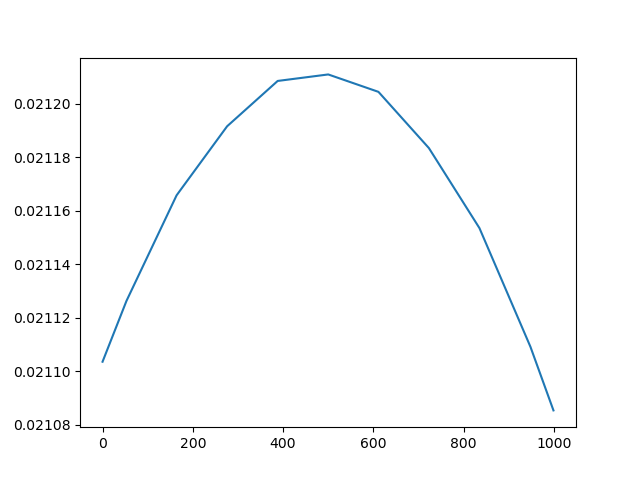

In [62]:
plt.plot(hp.get_interp_val(J_abs[:, 0, 1], np.radians(lat), np.radians(60), False, True))

<IPython.core.display.Javascript object>


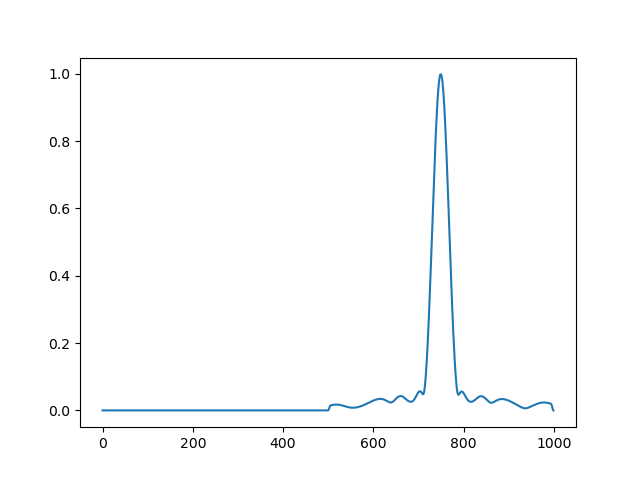

In [63]:
plt.plot(hp.get_interp_val(J_abs[:, 0, 1], -80, lon, False, True))

<IPython.core.display.Javascript object>


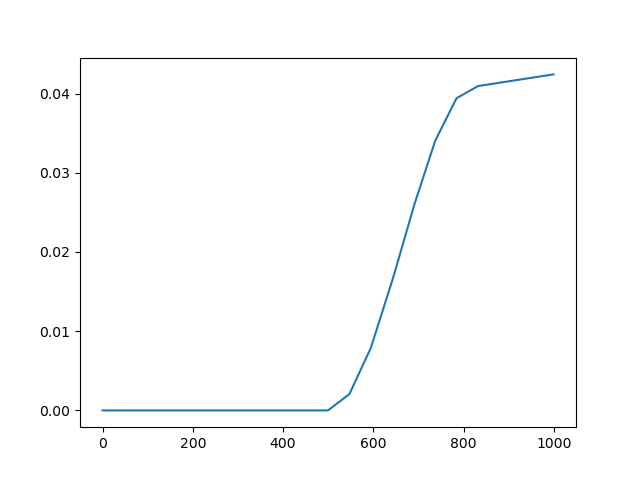

In [64]:
plt.plot(hp.get_interp_val(J_abs[:, 0, 1], np.radians(-80), np.radians(lon), False, True))

In [57]:
import rotations

In [46]:
print('HERA latitude:', rotations.lat)
print('HERA longitude:', rotations.lon)

HERA latitude: -30.72138888888889
HERA longitude: 21.428333333333335


In [47]:
el, be = rotations.eq_to_gal(rotations.lat, rotations.lon)
print('With right ascension = HERA latitude and declination = HERA longitude, we have:')
print('Galactic longitude:', el, 'Galactic latitude:', be)

With right ascension = HERA latitude and declination = HERA longitude, we have:
Galactic longitude: 77.522971004297 Galactic latitude: -25.693447620731042


In [48]:
def interp(J_section, el, be):
    '''
    Abbreviation and conversion function. We get the interpolation value
    assuming @al and @be are in degrees.
    '''
    colatitude = np.radians(90 - el)
    longitude = np.radians(be)
    return hp.get_interp_val(J_section, colatitude, longitude)

In [49]:
print('xx:', interp(J_abs[:, 1, 0], el, be))
print('xy:', interp(J_abs[:, 0, 0], el, be))
print('yx:', interp(J_abs[:, 1, 1], el, be))
print('yy:', interp(J_abs[:, 0, 1], el, be))

xx: 0.0642279359299459
xy: 0.02867011822452736
yx: 0.02909179377047776
yy: 0.03417988483452473


In [50]:
def bad_interp(J_section, alt, az):
    return hp.get_interp_val(J_section, alt, az, lonlat=True)

In [51]:
lst = 5.9147
az, alt = rotations.eq_to_topo(np.degrees(lst), rotations.lon, rotations.lat, np.degrees(lst))
print('HERA altitude:', az)
print('HERA azimuth:', alt)

HERA altitude: 4.0279720258405205e-15
HERA azimuth: 37.85027777777778


In [52]:
# Hard-coded corrections
altitude = -56.0848
azimuth = 263.1775

In [53]:
print('xx:', interp(J_abs[:, 1, 0], azimuth, altitude))
print('xy:', interp(J_abs[:, 0, 0], az, alt))
print('yx:', interp(J_abs[:, 1, 1], az, alt))
print('yy:', interp(J_abs[:, 0, 1], az, alt))

xx: 0.0
xy: 0.0
yx: 0.0
yy: 0.0


<IPython.core.display.Javascript object>


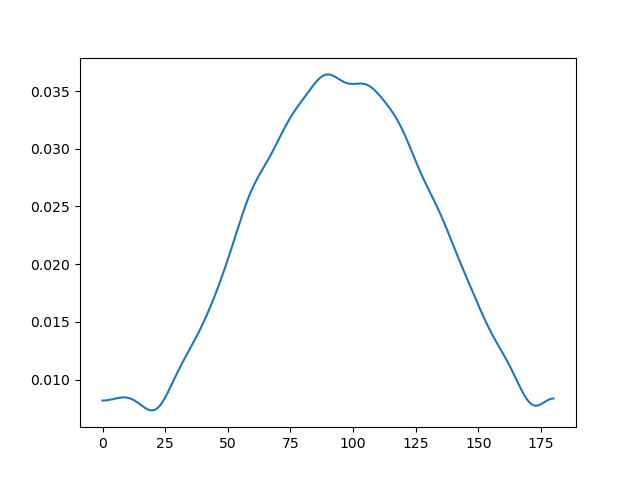

In [44]:
alts = np.linspace(0, 180, 181)
plt.plot(interp(J_abs[:, 1, 0], 20, alts))

In [59]:
from rotations import ha_to_gal
lst = 233.12405000887495
ha_to_gal(lst, rotations.lon, lst, radians=False)
#rotations.lon

ImportError: cannot import name 'ha_to_gal' from 'rotations' (/Users/lfinkbeiner/Documents/GitHub/HERA/rotations.py)

<IPython.core.display.Javascript object>


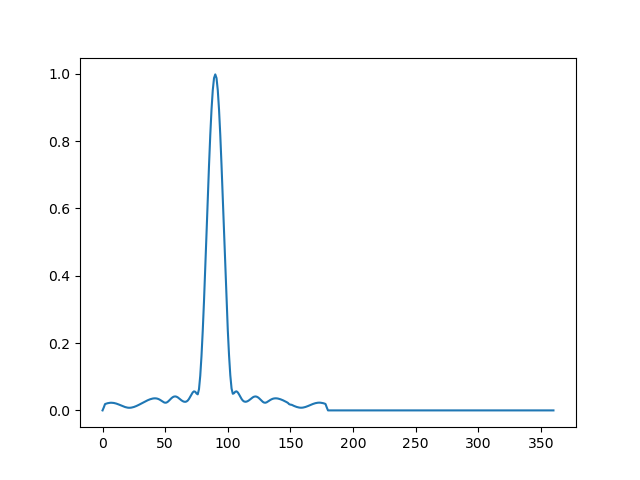

In [60]:
azs = np.linspace(0, 360, 361)
plt.plot(interp(J_abs[:, 1, 0], azs, 0))

<IPython.core.display.Javascript object>


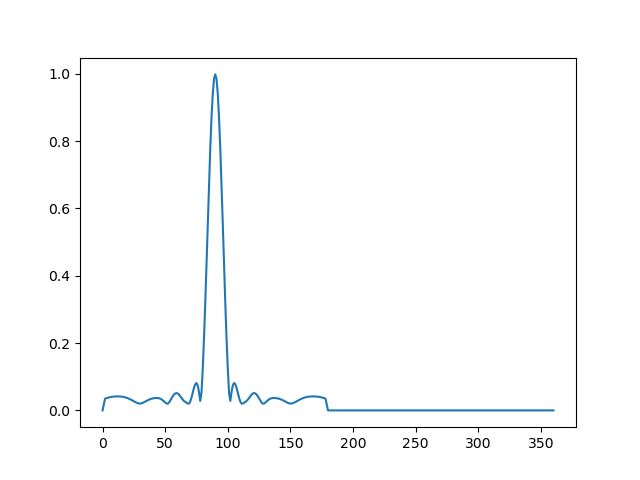

In [61]:
azs = np.linspace(0, 360, 361)
plt.plot(interp(J_abs[:, 1, 0], azs, 90))